<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [277]:
import numpy as np
import pandas as pd
import copy

import sklearn.datasets
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [278]:
RANDOM_STATE = 17

Необходимо реализовать класс `DecisionTree`

Спецификация:
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [279]:
def entropy(y):
    P = [len(y[y==k]) / len(y) for k in np.unique(y)]
    return -1 * np.dot(P, np.log2(P))

def gini(y):
    P = [len(y[y==k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(P, P)

# Regression criterion functions
def variance(y):
    return np.var(y)

def mad_median(y):
    return np.mean(np.abs(y-np.median(y)))

# Dictionary for easy mapping with input string
criterion_dict = {'entropy': entropy,
                  'gini': gini,
                  'mse': variance,
                  'mad_median' : mad_median}

In [280]:
# Target prediction functions

# the most popular class in leaf
def classification_leaf(y):
    return np.bincount(y).argmax()

# the mean of all values in a leaf
def regression_leaf(y):
    return np.mean(y)

In [281]:
class Node():

    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

In [282]:
class DecisionTree(BaseEstimator):

    def __init__(self,
                 max_depth:int=np.inf,
                 min_samples_split:int=2,
                 criterion='gini',
                 debug:bool=False):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.debug = debug

        self._criterion_fun = criterion_dict[self.criterion]

        if self.criterion in ['mse', 'mad_median']:
            self._leaf_value = regression_leaf
        else:
            self._leaf_value = classification_leaf

        if debug:
            print("DecisionTree")
            print(f"max_depth: {self.max_depth}, min_samples_split: {self.min_samples_split}, \
                  criterion: {self.criterion}, debug: {self.debug}")

    # A functional returns the gain achieved if we split the data at given feature and threshold value
    #
    def _functional(self, X, y, feature_idx, threshold):
        if threshold is np.nan:
            return 0

        mask = X[:,feature_idx] < threshold
        X_l = X[ mask ]
        y_l = y[ mask ]

        X_r = X[ ~mask ]
        y_r = y[ ~mask ]

        # if all the data goes to one of the child
        if len(X_l) == 0 or len(X_r) == 0:
            return 0

        return self._criterion_fun(y) - (X_l.shape[0]/X.shape[0])* self._criterion_fun(y_l) - (X_r.shape[0]/X.shape[0])* self._criterion_fun(y_r)


    # recursive function to split the data and form nodes
    #
    def _build_tree(self, X, y, depth = 1):

        # We already reached to the max_depth, so time to leave recursion
        # by creating a leaf Node
        if depth > self.max_depth:
            return Node(labels=y)

        n_samples, n_features = X.shape

        # We do not have sufficient samples to split
        if n_samples < self.min_samples_split:
            return Node(labels=y)

        # If all objects in a current vertex have the same values in answers
        # then the value of the functional will be 0 for all partitions.
        # So in this case the vertex is a leaf. In order not to make unnecessary calculations,
        # perform this check before the main cycle.
        if len(np.unique(y)) == 1:
            return Node(labels=y)

        # Here we are trying to split the data such that we will have maximun
        # gain out of split.
        # We will simulate the split for each unique value of each feature and
        # calculate the functional gain. On evey account of finding the maximum gain
        # from the previous we will keep storing the feature index and threshold value
        # which gave this gain.
        # At the end of this search we will have the best feature index and threshold
        # value we should use to split the data into left and right nodes.
        max_gain = 0
        best_feat_idx = 0
        best_threshold = 0

        for feature_idx in range(n_features):
            all_thresholds = np.unique(X[:,feature_idx])

            all_gain = [self._functional(X, y, feature_idx, threshold) for threshold in all_thresholds]

            threshold_idx = np.nanargmax(all_gain)

            if all_gain[threshold_idx] > max_gain:
                max_gain = all_gain[threshold_idx]
                best_feat_idx = feature_idx
                best_threshold = all_thresholds[threshold_idx]

        # Split data at this best feature and threshold
        mask = X[:,best_feat_idx] < best_threshold

        return Node(best_feat_idx, best_threshold, labels=None, # We need to cache labels only at leaf node
                    left = self._build_tree(X[mask], y[mask], depth+1), # continue to build on left side
                    right = self._build_tree(X[~mask], y[~mask], depth+1)) # continue to build on right side


    def fit(self, X, y):
        '''the method takes the matrix of instances X and a target vector y (numpy.ndarray objects)
        and returns an instance of the class DecisionTree representing the decision tree trained on the
        dataset (X, y) according to parameters set in the constructor'''

        # remember the number classes for classification task
        if self.criterion in ['gini', 'entropy']:
            self._n_classes = len(np.unique(y))

        self.root = self._build_tree(X, y)
        return self


    # predict only for one object
    def _predict_object(self, x):
        # Traverse from root to leaf node
        node = self.root

        while node.labels is None:
            node = node.left if x[node.feature_idx] < node.threshold else node.right

        # calculate the prediction
        return self._leaf_value(node.labels)


    def predict(self, X):
        '''the method takes the matrix of instances X and returns a prediction vector;
        in case of classification, prediction for an instance  xi  falling into leaf L will be the class,
        mostly represented among instances in  L .
        In case of regression, it will be the mean value of targets for all instances in leaf  L'''
        return np.array([self._predict_object(x) for x in X])


    def _predict_prob_object(self, x):
        node = self.root

        while node.labels is None:
            node = node.left if x[node.feature_idx] < node.threshold else node.right

        # calculate the probability of each class
        # i.e number of labels of class k / total number of labels
        return [len( node.labels[node.labels == k] ) / len(node.labels)
                for k in range(self._n_classes)]


    def predict_proba(self, X):
        '''the method takes the matrix of instances X and returns the matrix P of a size [X.shape[0] x K],
        where K is the number of classes and  Pij  is the probability of an instance in  i -th row of X
        to belong to class  j∈{1,…,K}'''
        return np.array([self._predict_prob_object(x) for x in X])

Тестирование реализованного алгоритма

Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [283]:
digits = load_digits()
print(digits.data.shape)

(1797, 64)


In [284]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=RANDOM_STATE)

In [285]:
%%time

model = DecisionTree(max_depth=100)
model.fit(X_train, y_train)

CPU times: user 5.49 s, sys: 8.89 ms, total: 5.5 s
Wall time: 5.54 s


DecisionTree(max_depth=100)

In [286]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.89      0.74      0.81        34
           2       0.88      0.82      0.85        34
           3       0.82      0.71      0.76        38
           4       0.89      0.82      0.86        40
           5       0.89      0.95      0.92        41
           6       0.88      0.88      0.88        32
           7       0.76      0.90      0.82        31
           8       0.68      0.75      0.71        36
           9       0.72      0.78      0.75        40

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.83       360
weighted avg       0.83      0.83      0.83       360



С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [287]:
kfold = 5

tree_params = {'max_depth': range(3,11),
               'criterion':['entropy', 'gini']}

model = DecisionTree()
tree_grid = GridSearchCV(model, tree_params, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=True)
tree_grid.fit(X_train, y_train)

tree_grid.best_params_,tree_grid.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


({'criterion': 'entropy', 'max_depth': 9}, 0.8434306039488966)

In [288]:
print(classification_report(y_test, tree_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        34
           1       0.97      0.82      0.89        34
           2       0.83      0.88      0.86        34
           3       0.90      0.74      0.81        38
           4       0.80      0.93      0.86        40
           5       0.89      0.95      0.92        41
           6       0.93      0.84      0.89        32
           7       0.88      0.97      0.92        31
           8       0.82      0.86      0.84        36
           9       0.90      0.90      0.90        40

    accuracy                           0.88       360
   macro avg       0.89      0.88      0.88       360
weighted avg       0.89      0.88      0.88       360



Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

In [289]:
df_plot = pd.DataFrame(tree_grid.cv_results_['params'])
df_plot['accuracy'] = tree_grid.cv_results_['mean_test_score']

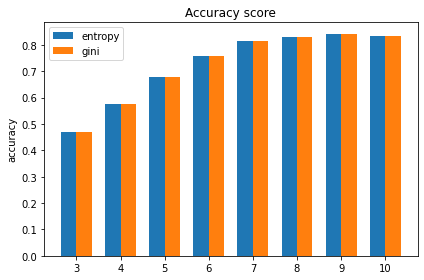

In [290]:
labels = df_plot.max_depth.sort_values().unique()
entropy = df_plot[df_plot.criterion=='entropy'].sort_values('max_depth').accuracy
gini = df_plot[df_plot.criterion=='gini'].sort_values('max_depth').accuracy

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, entropy, width, label='entropy')
rects2 = ax.bar(x + width/2, gini, width, label='gini')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('Accuracy score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Выберите верные утверждения:
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9].
2. На отрезке [3, 10] построенные графики не пересекаются.
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10].

Ответ:
1. Оптимальное значение max_depth для каждого критерия достигается на отрезке [4, 9] (tree_grid.best_params_ =  'max_depth': 8)
2. На отрезке [3, 10] построенные графики не пересекаются.

Чему равны найденные оптимальные значения параметров max_depth и criterion?
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Ответ:
ни один из перечисленных
max_depth = 8, criterion = 'entropy';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [291]:
def entropy(y):
    P = [len(y[y==k]) / len(y) for k in np.unique(y)]
    return -1 * np.dot(P, np.log2(P))

model = DecisionTree(max_depth=8, criterion='entropy')
model.fit(X_train, y_train)

DecisionTree(criterion='entropy', max_depth=8)

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

In [292]:
np.mean(model.predict_proba(X_test))

0.1

Вопрос: Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127
2. 0.118
3. 1.0
4. 0.09

Ответ: 0.09

In [293]:
np.std(np.array([1,2,3,4,5,6,7,8]))

2.29128784747792

In [294]:
np.std(np.array([1,2,1,2,3,4,2,1,1]))

0.9938079899999066

Регрессия

In [295]:
class DecisionTreeReg(BaseEstimator):

    def __init__(self, max_depth=np.inf, min_samples_split=2, criterion='variance', debug=False):

        self.max_depth = max_depth
        self.__max_depth_cnt__ = 0
        self.min_samples_split = min_samples_split
        self.debug = debug
        self.criterion = criterion
        self.__node__ = Node()

    def __calculation_information__(self, y):
        if self.criterion == 'variance':
            return variance(y)
        elif self.criterion == 'mad_median':
            return mad_median(y)

    def __split__(self, arr, cond):
        return (arr[cond], arr[~cond])


    def __information_gain__(self, information, left, right):
        base = left.shape[0] + right.shape[0]
        return information-(
                ((left.shape[0]/base)*self.__calculation_information__(left))+((right.shape[0]/base)*self.__calculation_information__(right)))

    def __build_tree__(self, tree, X, y, depth_cnt):

        tree.values_pred = copy.deepcopy(y)

        tree.information = self.__calculation_information__(y)

        if self.max_depth == depth_cnt:
            return

        depth_cnt+=1
        tree.depth = copy.deepcopy(depth_cnt)

        if tree.information == 0:
            return

        if self.min_samples_split >= X.shape[0]:
            return

        x = np.column_stack((X, y.reshape((-1, 1))[:, 0]))

        best_gain = 0
        best_feature = 0
        best_val = None

        for feature in range(x.shape[1]-1):
            for val in np.unique(x[:,feature]):
                (left, right) = self.__split__(x,x[:,feature]<val)

                if left[:,-1].shape[0]!=0 and right[:,-1].shape[0]!=0:
                    next_gain = self.__information_gain__(tree.information, left[:,-1], right[:,-1])
                    if best_gain < next_gain:
                        best_gain = copy.deepcopy(next_gain)
                        best_feature = copy.deepcopy(feature)
                        best_val = copy.deepcopy(val)

        if best_val is None:
            best_val = np.median(x[:,best_feature])

        tree.splitting_feature = copy.deepcopy(best_feature)
        tree.splitting_values = copy.deepcopy(best_val)

        (left, right) = self.__split__(x,x[:,best_feature]<best_val)

        tree.left = Node()
        self.__build_tree__(tree=tree.left, X=left[:,:-1], y=left[:,-1], depth_cnt=tree.depth)

        tree.right = Node()
        self.__build_tree__(tree=tree.right, X=right[:,:-1], y=right[:,-1], depth_cnt=tree.depth)


    def fit(self, X, y):
        self.__build_tree__(tree=self.__node__, X=X, y=y, depth_cnt=self.__max_depth_cnt__)


    def __predict_tree__(self, tree, x):

        if tree.right is None and tree.left is None:
            return tree.values_pred

        if x[tree.splitting_feature]<tree.splitting_values:
            if tree.left is None:
                return tree.values_pred
            return self.__predict_tree__(tree.left, x)

        else:
            if tree.right is None:
                return tree.values_pred
            return self.__predict_tree__(tree.right, x)



    def predict(self, X):
        pred = []
        for i in X:
            y = self.__predict_tree__(self.__node__, i)
            pred.append(np.mean(y))
        return np.array(pred)


    def score(self, X, y):
        return mean_squared_error(y, self.predict(X))

In [296]:
boston  = sklearn.datasets.load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.2, random_state=RANDOM_STATE)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset 

In [297]:
model = DecisionTreeReg(criterion='variance')
model.fit(X_train, y_train)
model.score(X_test, y_test)

11.382647058823528

In [298]:
model = DecisionTreeReg(criterion='mad_median')
model.fit(X_train, y_train)
model.score(X_test, y_test)

15.262622549019609

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [299]:
kfold = 5

tree_params = {'max_depth': range(2,9),
               'criterion':['variance', 'mad_median']}

model = DecisionTreeReg()
tree_grid = GridSearchCV(model, tree_params, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

tree_grid.best_params_,tree_grid.best_score_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


({'criterion': 'mad_median', 'max_depth': 4}, -21.157004600133206)

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

In [300]:
df_plot = pd.DataFrame(tree_grid.cv_results_['params'])
df_plot['accuracy'] = tree_grid.cv_results_['mean_test_score']

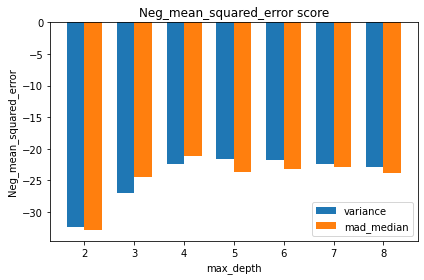

In [301]:
labels = df_plot.max_depth.sort_values().unique()
variance = df_plot[df_plot.criterion=='variance'].sort_values('max_depth').accuracy
mad_median = df_plot[df_plot.criterion=='mad_median'].sort_values('max_depth').accuracy

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, variance, width, label='variance')
rects2 = ax.bar(x + width/2, mad_median, width, label='mad_median')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Neg_mean_squared_error')
ax.set_xlabel('max_depth')
ax.set_title('Neg_mean_squared_error score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Выберите верные утверждения:
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`.

Ответ:
3. Оптимальное значение max_depth для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при max_depth из [2, 8] достигается при использовании критерия mad_median.

Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance';